In [4]:
from comet_ml import API
import pandas as pd
import os
import sys
import pickle
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss, average_precision_score

current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'scripts'))

from Plots import Centiles_plot, ROC_plot, cumulative_centiles_plot, calibrate_display
from feature_engineering import preprocessing

test_data1 = pd.read_csv('../data/derivatives/test_data_saison_eli.csv')
test_data2 = pd.read_csv('../data/derivatives/test_data_saison_reg.csv')


In [5]:
def visualisation(model_name, best_model, y_probs, y_test, X_test):
    y_test = pd.Series(y_test)
    CLFS = [[[best_model], X_test, model_name] ]
    Ys=[[model_name, y_probs[:,1], "blue", True] ]
    
    print(f"Résultats pour le modèle : {model_name}")

    ROC_plot(y_test, Ys)
    Centiles_plot(y_test, Ys)
    cumulative_centiles_plot(y_test, Ys)
    calibrate_display(CLFS, y_test, n_bin = 40)

COMET INFO: Downloading registry model 'xgboost', version '1.4.0', stage None from workspace 'me-pic'...
COMET INFO: Unzipping model to 'c:\\Users\\lebou\\Desktop\\Cours_Canada\\Data_science_IFT6758\\project_nhl_data\\ift6758-A08\\model\\xgboost' ...
COMET INFO: done!


roc_auc_score for xgboost on test_data1: 0.8130643993456665
average_precision for xgboost on test_data1: 0.3680251224834943
log_loss for xgboost on test_data1: 0.244333797969171
brier_score for xgboost on test_data1: 0.06983909093068022
Résultats pour le modèle : xgboost
Métrique AUC : {'xgboost': 0.8130643993456665}


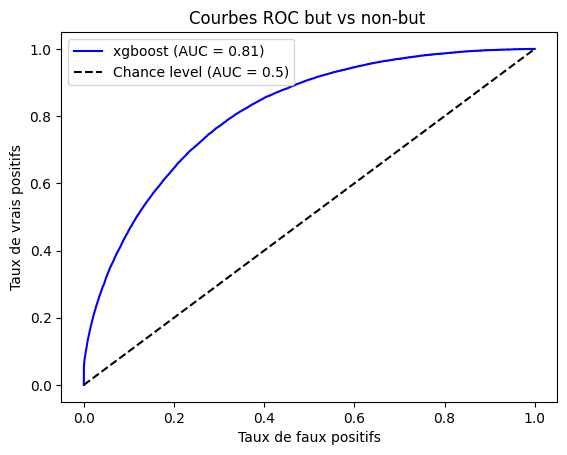

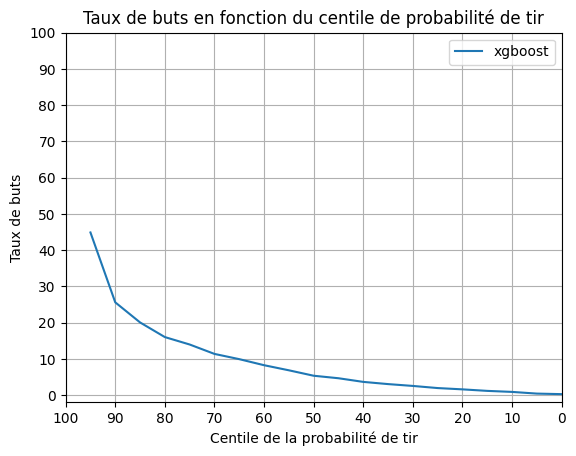

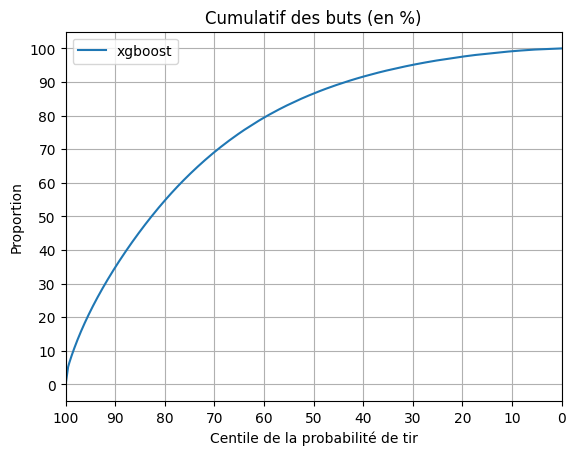

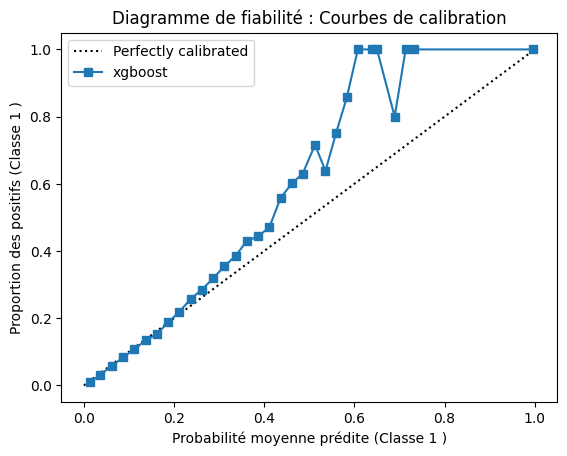

roc_auc_score for xgboost on test_data2: 0.8130643993456665
average_precision for xgboost on test_data2: 0.3680251224834943
log_loss for xgboost on test_data2: 0.244333797969171
brier_score for xgboost on test_data2: 0.06983909093068022
Résultats pour le modèle : xgboost
Métrique AUC : {'xgboost': 0.8130643993456665}


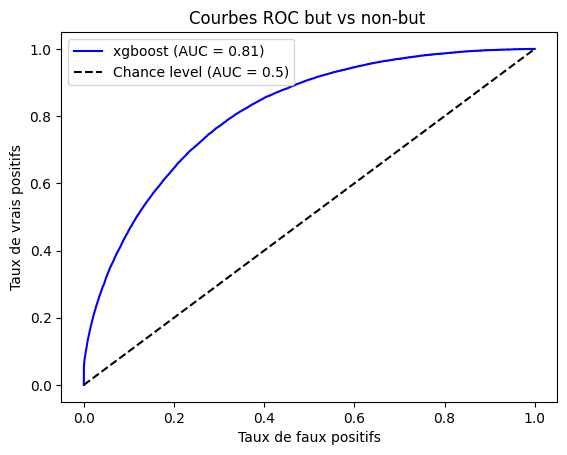

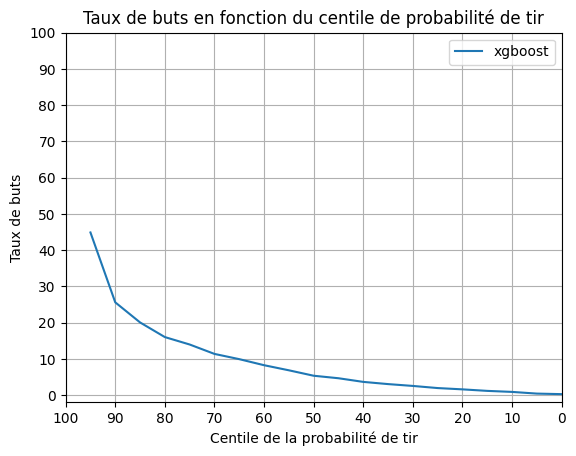

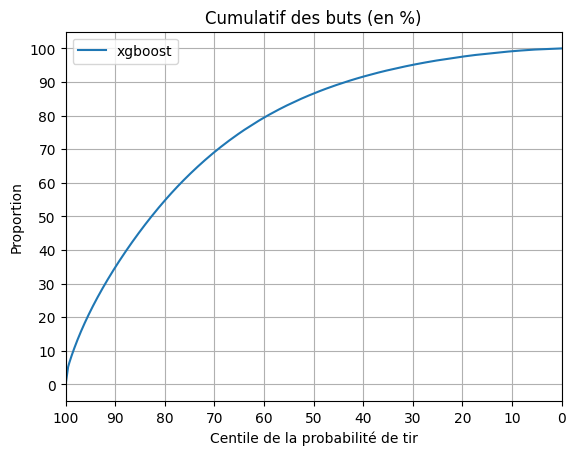

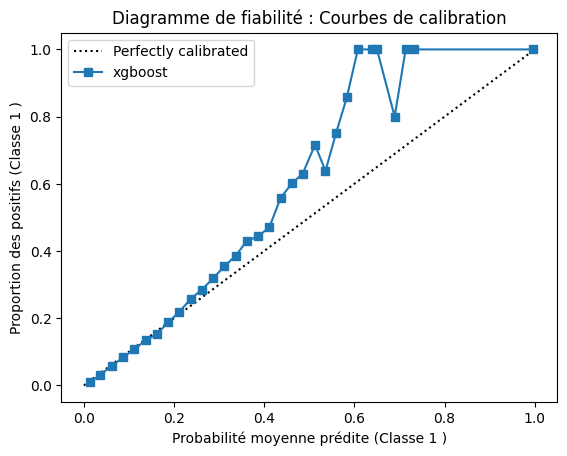

COMET INFO: Downloading registry model 'logistic_reg_angle', version '1.1.0', stage None from workspace 'me-pic'...
COMET INFO: Unzipping model to 'c:\\Users\\lebou\\Desktop\\Cours_Canada\\Data_science_IFT6758\\project_nhl_data\\ift6758-A08\\model\\logistic_reg_angle' ...
COMET INFO: done!
c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


roc_auc_score for logistic_reg_angle on test_data1: 0.5013603679418949
average_precision for logistic_reg_angle on test_data1: 0.09015213561336435
log_loss for logistic_reg_angle on test_data1: 0.30565235541653035
brier_score for logistic_reg_angle on test_data1: 0.08299133522491597
Résultats pour le modèle : logistic_reg_angle
Métrique AUC : {'logistic_reg_angle': 0.5013603679418949}


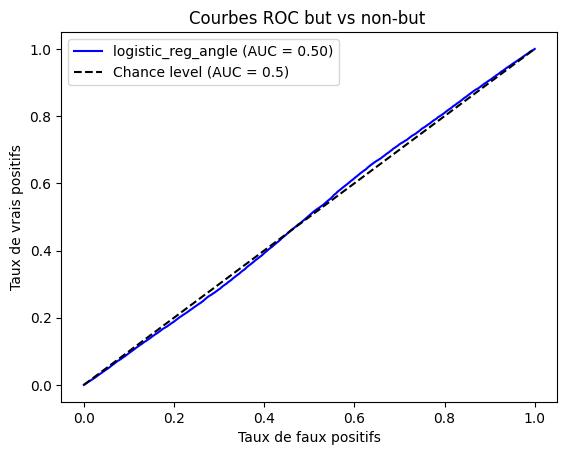

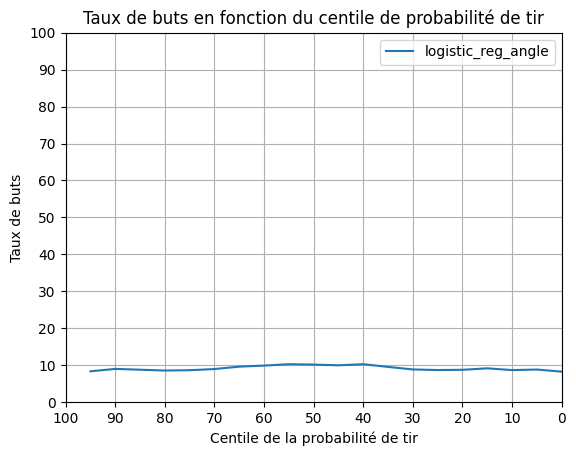

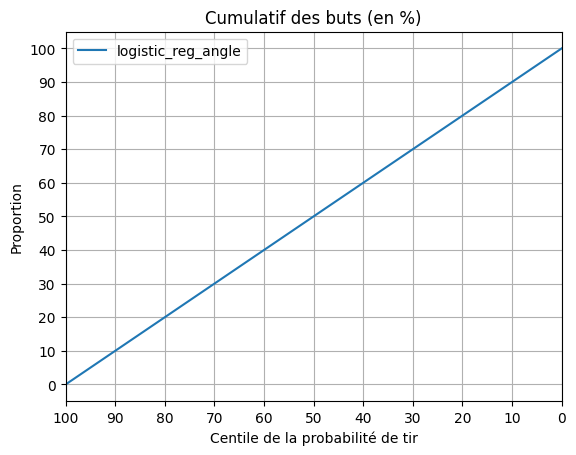

c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


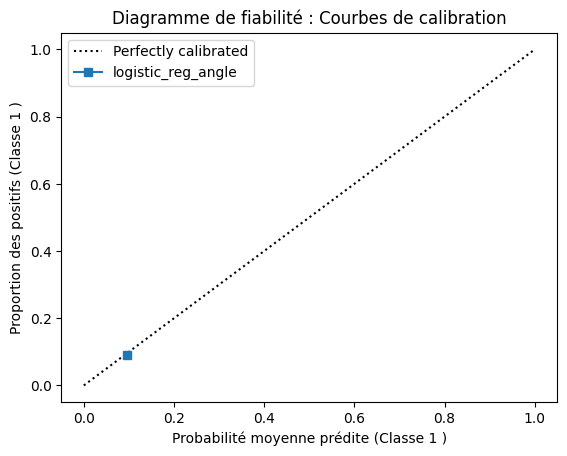

c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


roc_auc_score for logistic_reg_angle on test_data2: 0.5013603679418949
average_precision for logistic_reg_angle on test_data2: 0.09015213561336435
log_loss for logistic_reg_angle on test_data2: 0.30565235541653035
brier_score for logistic_reg_angle on test_data2: 0.08299133522491597
Résultats pour le modèle : logistic_reg_angle
Métrique AUC : {'logistic_reg_angle': 0.5013603679418949}


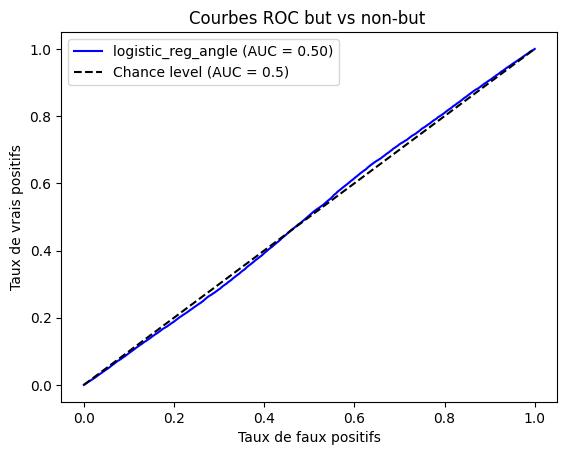

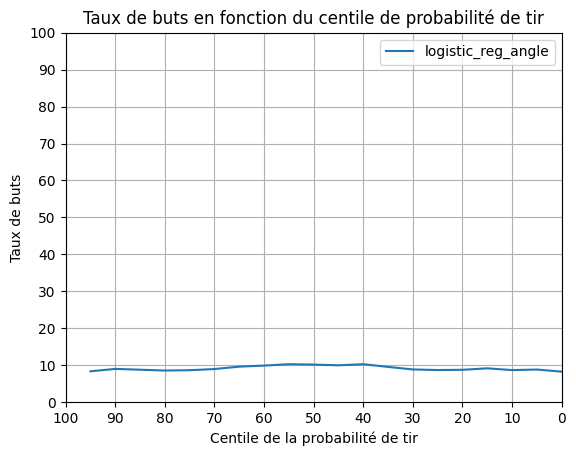

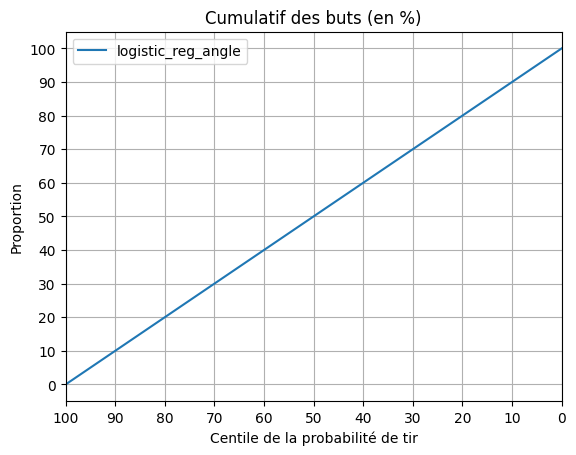

c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


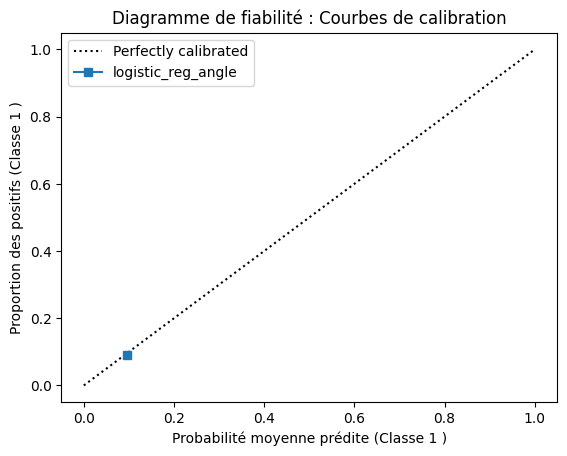

COMET INFO: Downloading registry model 'logistic_reg_dist-angle', version '1.1.0', stage None from workspace 'me-pic'...
COMET INFO: Unzipping model to 'c:\\Users\\lebou\\Desktop\\Cours_Canada\\Data_science_IFT6758\\project_nhl_data\\ift6758-A08\\model\\logistic_reg_dist-angle' ...
COMET INFO: done!


roc_auc_score for logistic_reg_dist-angle on test_data1: 0.5476289828849552
average_precision for logistic_reg_dist-angle on test_data1: 0.10630845805606626
log_loss for logistic_reg_dist-angle on test_data1: 0.39350776490284994
brier_score for logistic_reg_dist-angle on test_data1: 0.1102663855197523
Résultats pour le modèle : logistic_reg_dist-angle
Métrique AUC : {'logistic_reg_dist-angle': 0.5476289828849552}


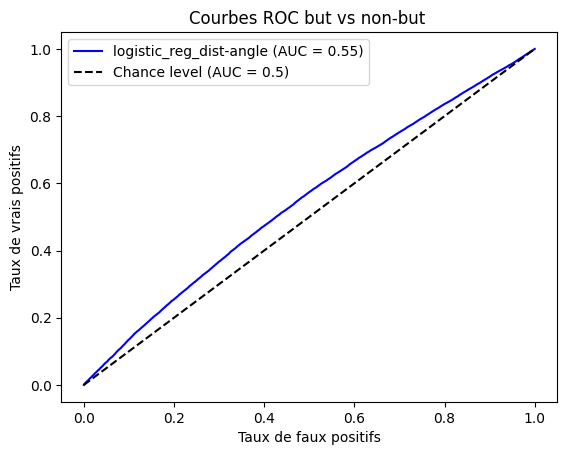

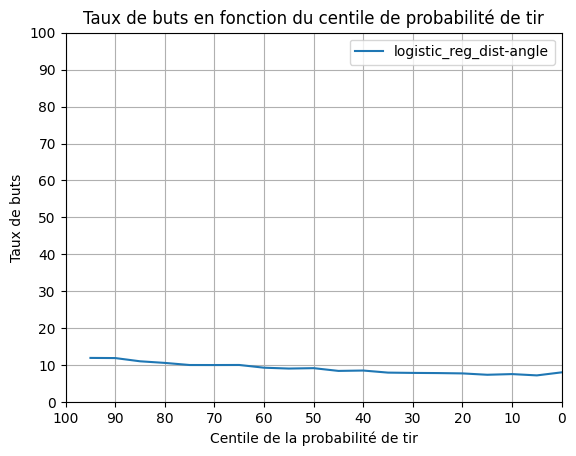

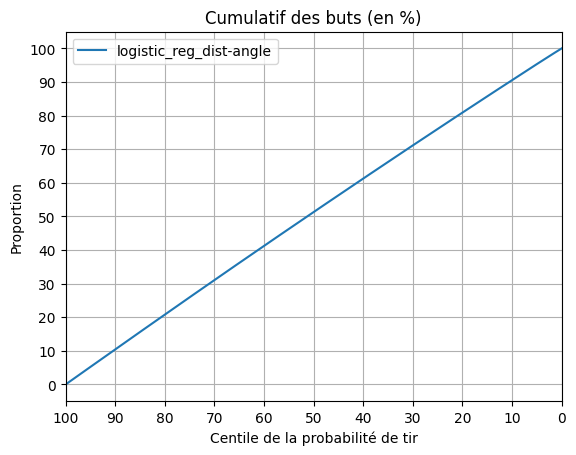

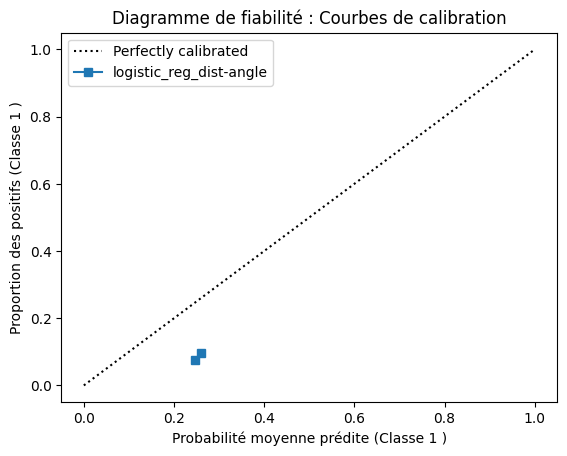

roc_auc_score for logistic_reg_dist-angle on test_data2: 0.5476289828849552
average_precision for logistic_reg_dist-angle on test_data2: 0.10630845805606626
log_loss for logistic_reg_dist-angle on test_data2: 0.39350776490284994
brier_score for logistic_reg_dist-angle on test_data2: 0.1102663855197523
Résultats pour le modèle : logistic_reg_dist-angle
Métrique AUC : {'logistic_reg_dist-angle': 0.5476289828849552}


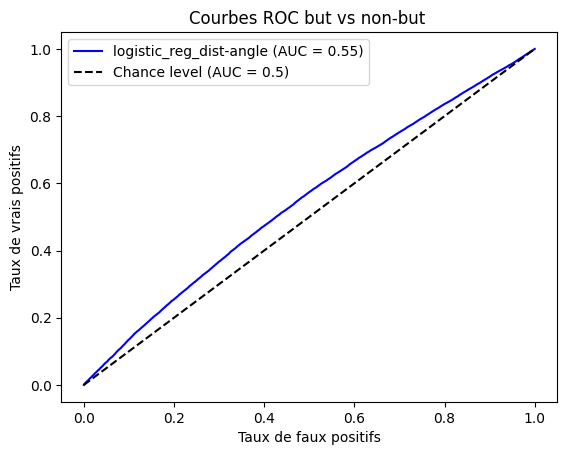

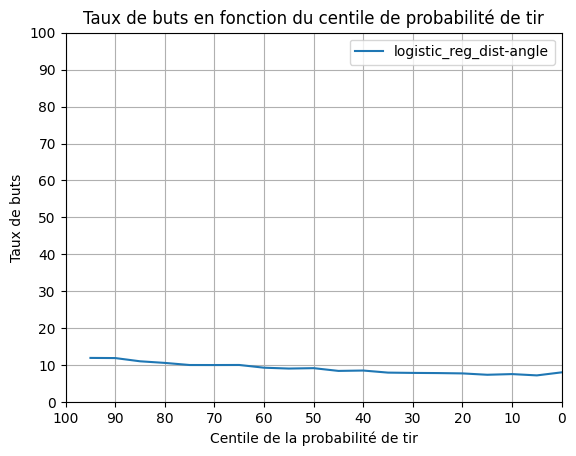

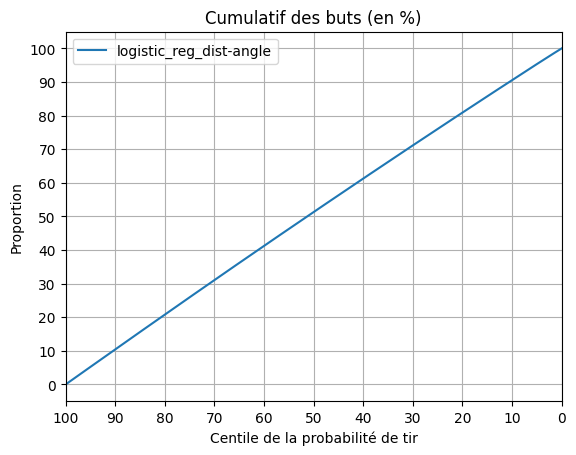

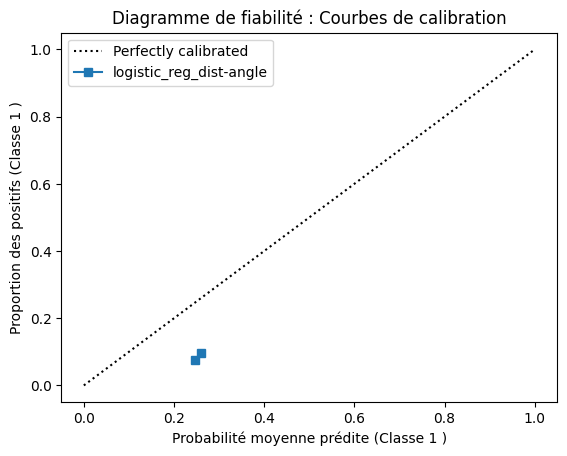

COMET INFO: Downloading registry model 'logistic_reg_distance', version '1.1.0', stage None from workspace 'me-pic'...
COMET INFO: Unzipping model to 'c:\\Users\\lebou\\Desktop\\Cours_Canada\\Data_science_IFT6758\\project_nhl_data\\ift6758-A08\\model\\logistic_reg_distance' ...
COMET INFO: done!
c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


roc_auc_score for logistic_reg_distance on test_data1: 0.5475951842737645
average_precision for logistic_reg_distance on test_data1: 0.10626279057148037
log_loss for logistic_reg_distance on test_data1: 0.3934058824585857
brier_score for logistic_reg_distance on test_data1: 0.11022751256835646
Résultats pour le modèle : logistic_reg_distance
Métrique AUC : {'logistic_reg_distance': 0.5475951842737645}


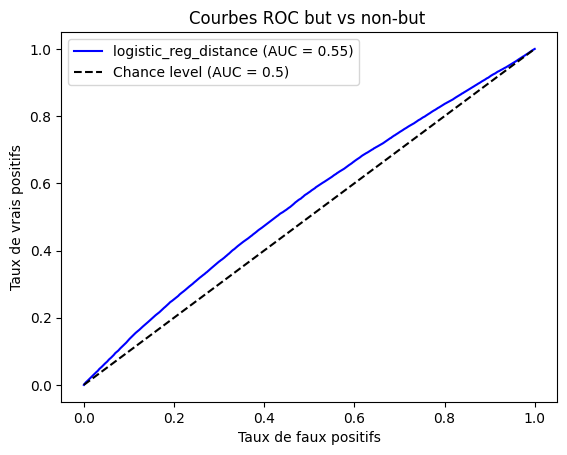

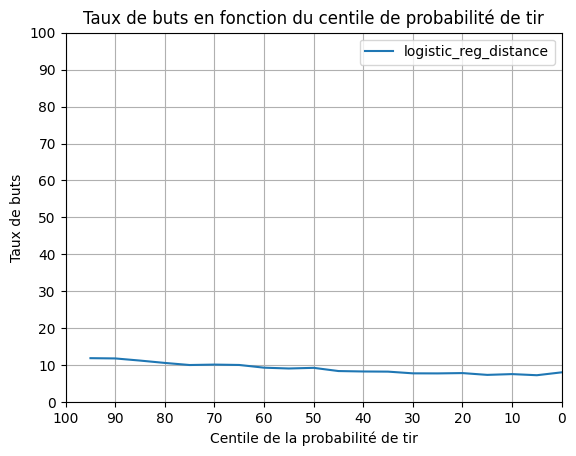

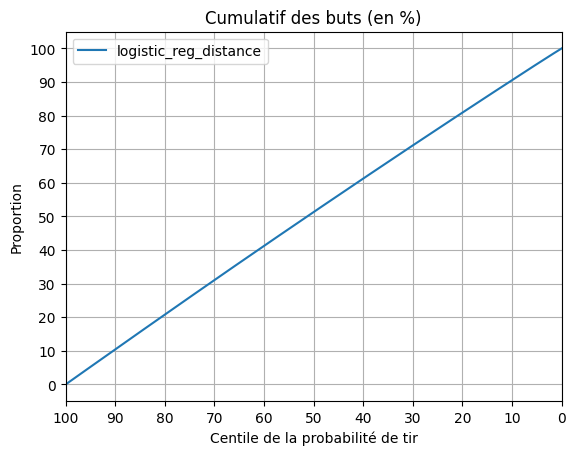

c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


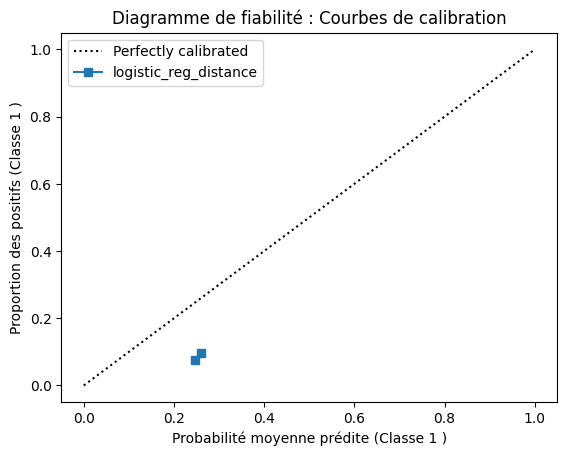

c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


roc_auc_score for logistic_reg_distance on test_data2: 0.5475951842737645
average_precision for logistic_reg_distance on test_data2: 0.10626279057148037
log_loss for logistic_reg_distance on test_data2: 0.3934058824585857
brier_score for logistic_reg_distance on test_data2: 0.11022751256835646
Résultats pour le modèle : logistic_reg_distance
Métrique AUC : {'logistic_reg_distance': 0.5475951842737645}


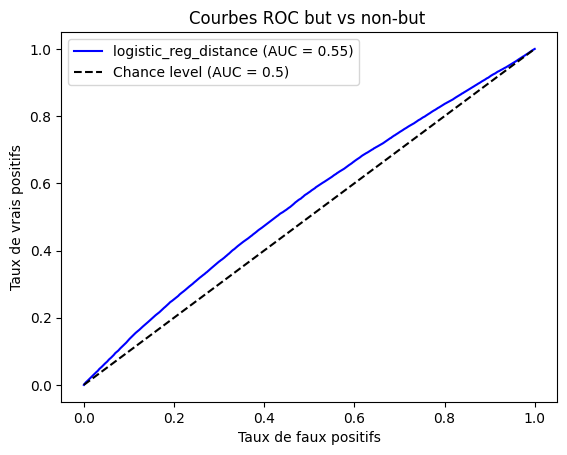

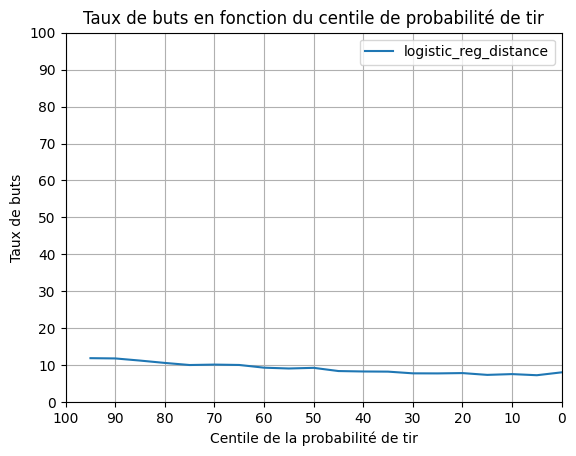

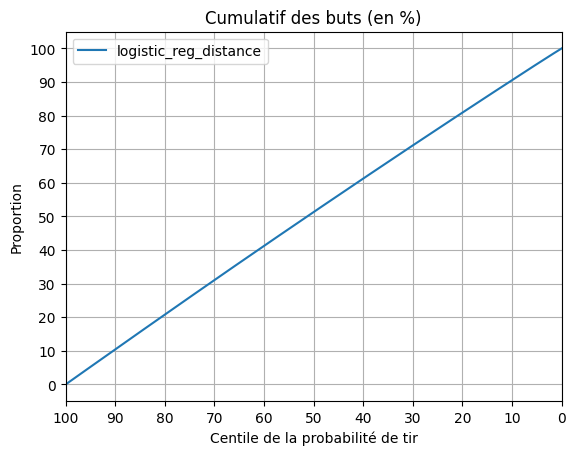

c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


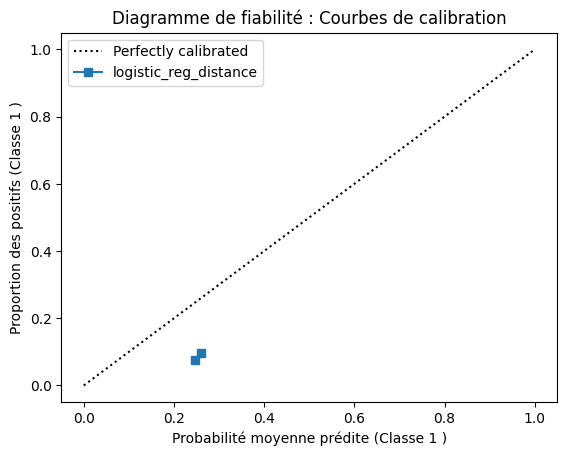

COMET INFO: Downloading registry model 'boosted_logistic_reg', version '1.0.0', stage None from workspace 'me-pic'...
COMET INFO: Unzipping model to 'c:\\Users\\lebou\\Desktop\\Cours_Canada\\Data_science_IFT6758\\project_nhl_data\\ift6758-A08\\model\\boosted_logistic_reg' ...
COMET INFO: done!
c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


roc_auc_score for boosted_logistic_reg on test_data1: 0.7908396575820075
average_precision for boosted_logistic_reg on test_data1: 0.32450847373912955
log_loss for boosted_logistic_reg on test_data1: 0.2532491403659939
brier_score for boosted_logistic_reg on test_data1: 0.07192906095071673
Résultats pour le modèle : boosted_logistic_reg
Métrique AUC : {'boosted_logistic_reg': 0.7908396575820075}


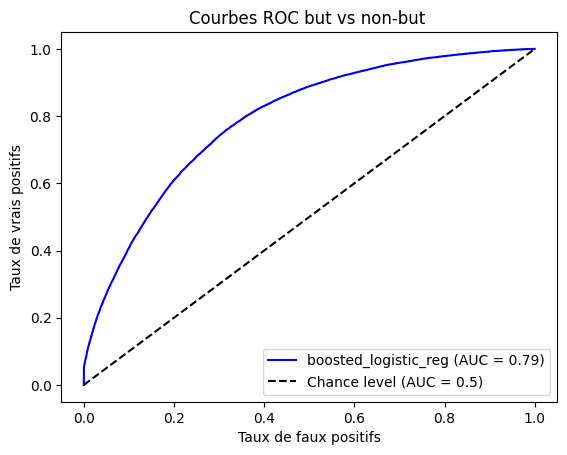

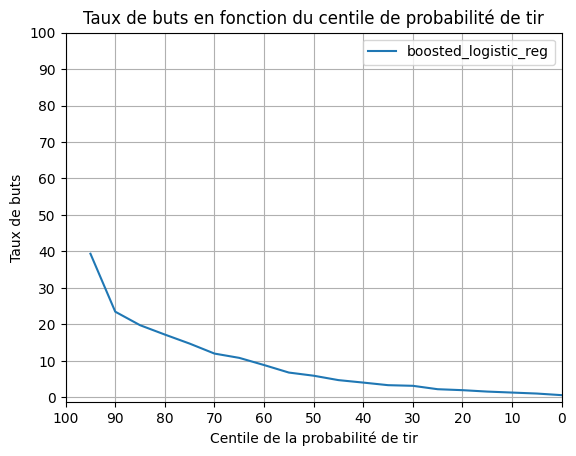

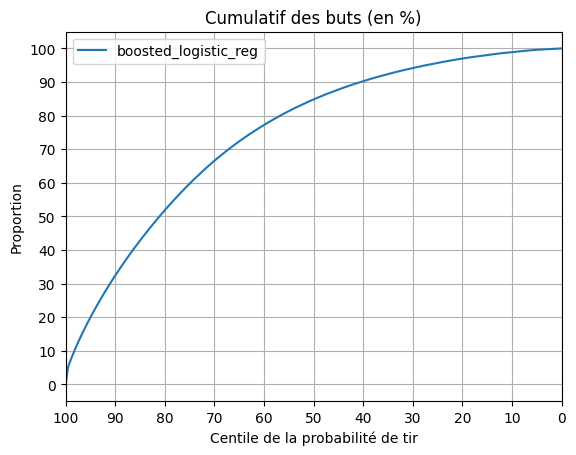

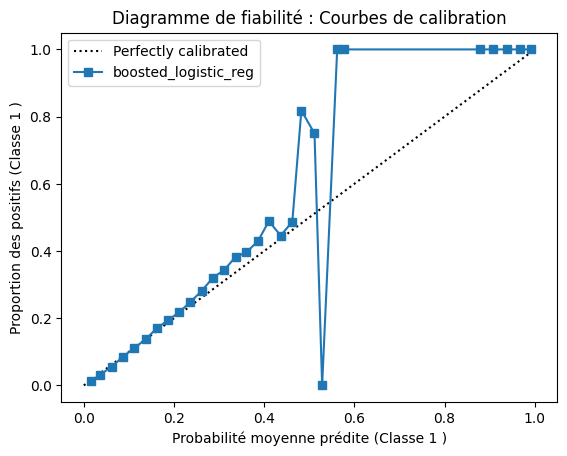

roc_auc_score for boosted_logistic_reg on test_data2: 0.7908396575820075
average_precision for boosted_logistic_reg on test_data2: 0.32450847373912955
log_loss for boosted_logistic_reg on test_data2: 0.2532491403659939
brier_score for boosted_logistic_reg on test_data2: 0.07192906095071673
Résultats pour le modèle : boosted_logistic_reg
Métrique AUC : {'boosted_logistic_reg': 0.7908396575820075}


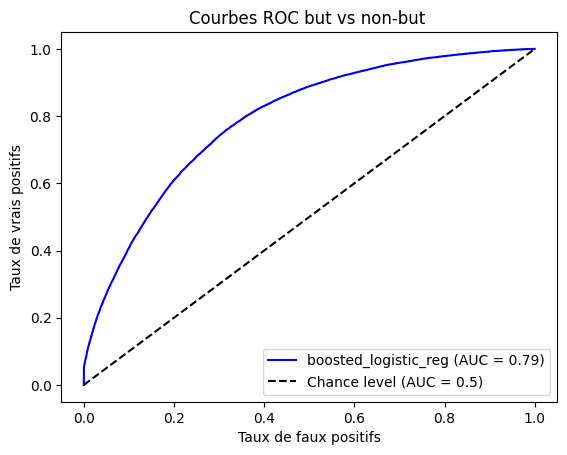

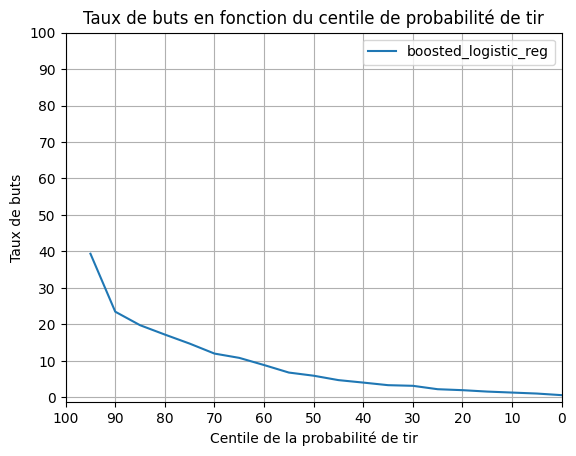

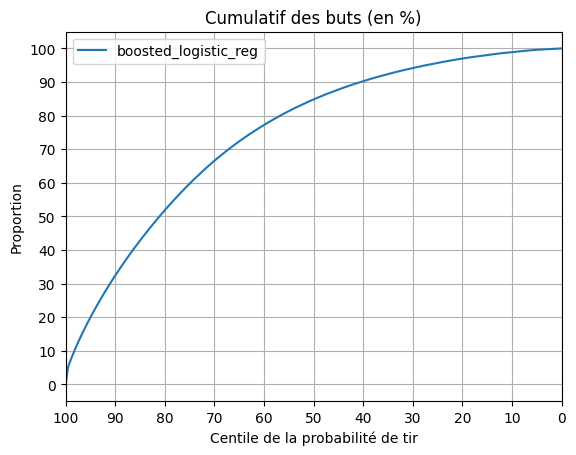

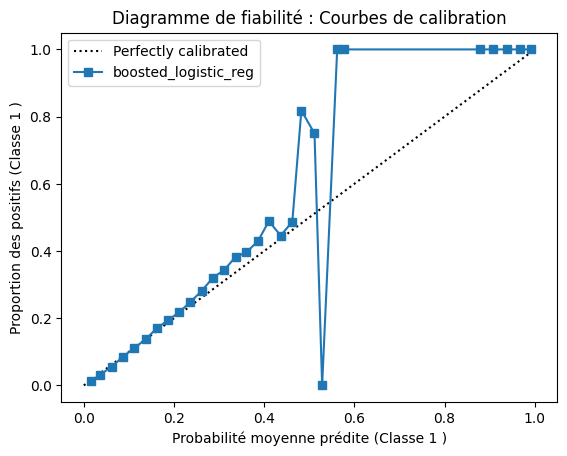

In [6]:
API_KEY = os.environ.get('COMET_API_KEY')
project_name = "milestone-2"
workspace = "me-pic"

api = API(api_key=API_KEY)

model_list = [    
    ("xgboost", "1.4.0", 'full'),  # 'full' signifie utiliser test_data1 et test_data2
    ("logistic_reg_angle", "1.1.0", 'angle'),  # 'logistic' signifie utiliser test_logistic
    ('logistic_reg_dist-angle', "1.1.0", 'dist-angle'),
    ('logistic_reg_distance', "1.1.0", 'distance'),
    ('boosted_logistic_reg', "1.0.0", 'full')
    ]

test_datasets = [('test_data1', test_data1), ('test_data2', test_data2)]

for model_name, model_version, data_type in model_list:
    try:
        output_path = f"../model/{model_name}"
        api.download_registry_model(workspace, model_name, model_version, output_path=output_path, expand=True)
        file_name = os.listdir(f'../model/{model_name}')
        
        with open(os.path.join(output_path, file_name[0]), 'rb') as file:
            model = pickle.load(file)
        
        for dataset_name, dataset in test_datasets:
            if data_type == 'full':
                X, y = preprocessing(dataset, 'is_goal')
            elif data_type == 'angle':
                X, y = preprocessing(dataset, 'is_goal')
                X = X[['shot_angle']]
            elif data_type == 'distance':
                X, y = preprocessing(dataset, 'is_goal')
                X = X[['shot_distance']]
            elif data_type == 'dist-angle':
                X, y = preprocessing(dataset, 'is_goal')
                X = X[['shot_distance', 'shot_angle']]
            
            predictions = model.predict_proba(X)
            
            # Calcul et affichage des métriques pour chaque modèle et dataset
            metrics = roc_auc_score(y, predictions[:, 1])
            print(f"roc_auc_score for {model_name} on {dataset_name}: {metrics}")

            metrics = average_precision_score(y, predictions[:, 1])
            print(f"average_precision for {model_name} on {dataset_name}: {metrics}")

            metrics = log_loss(y, predictions)
            print(f"log_loss for {model_name} on {dataset_name}: {metrics}")

            metrics= brier_score_loss(y, predictions[:, 1])
            print(f"brier_score for {model_name} on {dataset_name}: {metrics}")

            visualisation(model_name, model, predictions, y, X)

    except Exception as e:
        print(f"An error occurred with {model_name}: {e}")


